<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

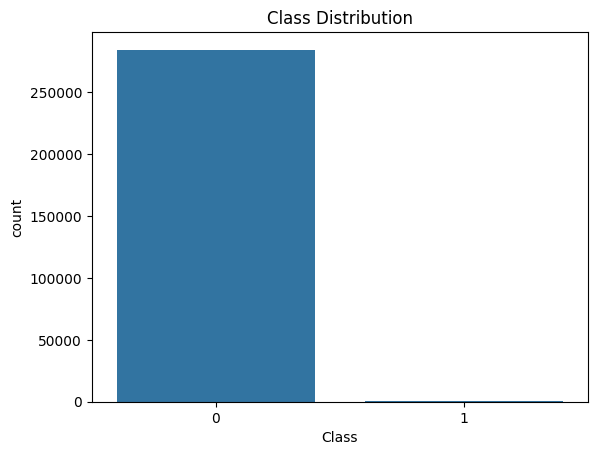

Fraud Rate:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


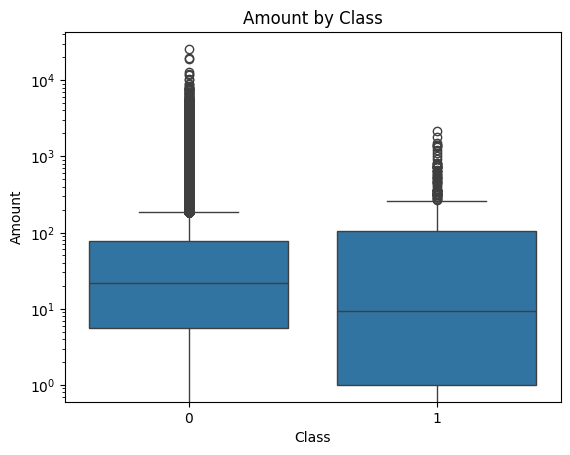

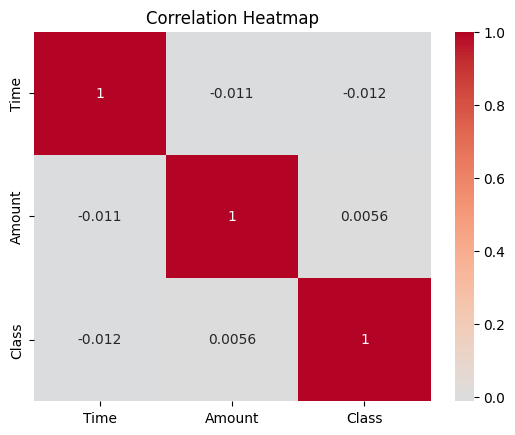

After SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64

=== Logistic Regression ===
Confusion Matrix:
 [[85277    18]
 [   35   113]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.76      0.81       148

    accuracy                           1.00     85443
   macro avg       0.93      0.88      0.90     85443
weighted avg       1.00      1.00      1.00     85443

Accuracy: 99.94%
ROC-AUC: 0.9655
PR-AUC: 0.7443
Optimal Threshold: 1.0000

=== Random Forest ===
Confusion Matrix:
 [[85282    13]
 [   33   115]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Acc

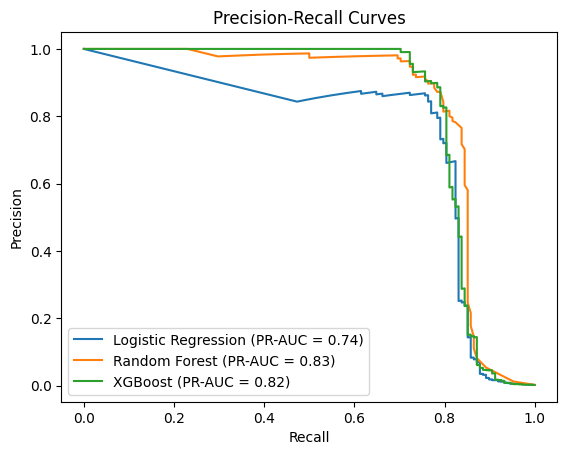

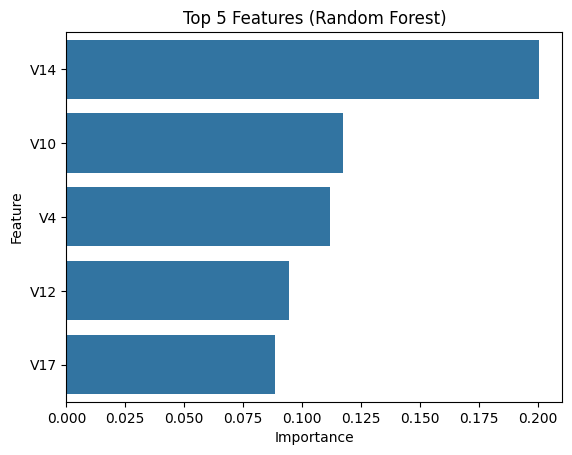

Top 5 Features:
    Feature  Importance
14     V14    0.200544
10     V10    0.117308
4       V4    0.111884
12     V12    0.094398
17     V17    0.088770
Total Fraud Cost: $1931189.00
Detected Fraud Cost (Random Forest): $1201526.00
Cost Saved: $729663.00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c58668a52f9a568e35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Credit Card Fraud Detection (Classification)

# ## 1. Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import json
import gradio as gr

# Load dataset
df = pd.read_csv("creditcard.csv")

# Check info and missing values
print(df.info())
print("Missing values:\n", df.isnull().sum())

# Class distribution
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

# Fraud rate
fraud_rate = df['Class'].value_counts(normalize=True) * 100
print(f"Fraud Rate:\n{fraud_rate}")

# Boxplot by class
sns.boxplot(x='Class', y='Amount', data=df)
plt.yscale('log')
plt.title('Amount by Class')
plt.show()

# Correlation heatmap
sns.heatmap(df[['Time', 'Amount', 'Class']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# ## 2. Data Preprocessing
scaler = RobustScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE:\n{pd.Series(y_train_smote).value_counts()}")

# ## 3. Model Building
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    accuracy = accuracy_score(y_test, y_pred) * 100

    results[name] = {
        'confusion_matrix': cm,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'model': model,
        'threshold': optimal_threshold,
        'y_pred': y_pred
    }

    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Model Comparison
comparison = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy (%)': [results[model]['accuracy'] for model in results],
    'Precision': [results[model]['precision'] for model in results],
    'Recall': [results[model]['recall'] for model in results],
    'F1-Score': [results[model]['f1'] for model in results],
    'ROC-AUC': [results[model]['roc_auc'] for model in results],
    'PR-AUC': [results[model]['pr_auc'] for model in results]
})
print("\nModel Comparison:\n", comparison)

# PR-AUC Curves
plt.figure()
for name, result in results.items():
    y_pred_proba = result['model'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision, label=f"{name} (PR-AUC = {result['pr_auc']:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

# Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(5)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 5 Features (Random Forest)')
plt.show()
print("Top 5 Features:\n", feature_importance)

# ## 4. Business Impact Analysis
amount_unscaled = scaler.inverse_transform(df[['Time', 'Amount']])[:, 1]
test_indices = y_test.index
fraud_cost = np.sum(amount_unscaled[test_indices][y_test == 1] * 100)
detected_fraud_cost = np.sum(amount_unscaled[test_indices][(y_test == 1) & (results['Random Forest']['y_pred'] == 1)] * 100)
print(f"Total Fraud Cost: ${fraud_cost:.2f}")
print(f"Detected Fraud Cost (Random Forest): ${detected_fraud_cost:.2f}")
print(f"Cost Saved: ${(fraud_cost - detected_fraud_cost):.2f}")

# ## 5. Gradio Deployment
with open('fraud_detection_model.pkl', 'wb') as f:
    pickle.dump(results['Random Forest']['model'], f)

columns = { 'data_columns': [col.lower() for col in X.columns] }
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))

with open('fraud_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('columns.json', 'r') as f:
    data_columns = json.load(f)['data_columns']

def predict_fraud(amount, time, v1, v2):
    x = np.zeros(len(data_columns))
    x[data_columns.index('amount')] = (amount - df['Amount'].median()) / (df['Amount'].quantile(0.75) - df['Amount'].quantile(0.25))
    x[data_columns.index('time')] = (time - df['Time'].median()) / (df['Time'].quantile(0.75) - df['Time'].quantile(0.25))
    x[data_columns.index('v1')] = v1
    x[data_columns.index('v2')] = v2
    fraud_prob = model.predict_proba([x])[0][1]
    fraud_pred = 'Fraudulent' if fraud_prob >= results['Random Forest']['threshold'] else 'Legitimate'
    return f"Prediction: {fraud_pred} (Fraud Probability: {fraud_prob:.2%})"

iface = gr.Interface(
    fn=predict_fraud,
    inputs=[
        gr.Slider(minimum=0, maximum=1000, step=1, label="Transaction Amount ($)", value=100),
        gr.Slider(minimum=0, maximum=172792, step=1, label="Time (Seconds)", value=3600),
        gr.Slider(minimum=-5, maximum=5, step=0.1, label="V1 (PCA Feature)", value=0),
        gr.Slider(minimum=-5, maximum=5, step=0.1, label="V2 (PCA Feature)", value=0)
    ],
    outputs="text",
    title="💳 Credit Card Fraud Detector",
    description="Enter transaction details to predict if it's fraudulent."
)
iface.launch()